In [1]:
  import pandas as pd
from string import punctuation
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import io
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPool1D,BatchNormalization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
data=pd.read_csv("/kaggle/input/toxicity/train.csv")

In [4]:
# Function to remove URLs and IP addresses
def remove_urls_and_ip(text):
    text = re.sub(r'http\S+|www.\S+|\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)
    return text

In [5]:
# Function to perform lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [6]:
# Iterate over each row in the 'column_text' column
for index, row in data.iterrows():
    text = row['comment_text']
    text = text.lower() # Convert the text to lowercase
    text = re.sub(r'\w*\d\w*', '', text) # Removing Characters in between Text
    text = re.sub(r'(.)\1+', r'\1', text) # Removing Repeated Characters
    text = text.translate(str.maketrans('', '', punctuation)) # Punctuation removal
    text = re.sub(r'\d+', '', text) # Number removal
    text = re.sub(r'\s+', ' ', text)# Removing unnecessary white spaces in between words
    text = text.replace('\n', ' ') # Removing "\n"
    text = re.sub(r'[^\x00-\x7F]+', '', text)# Removing Non-English characters
    text = remove_urls_and_ip(text)# Removing URLs and IP addresses
   # text = lemmatize_text(text)# Lemmatization
    stop_words = set(stopwords.words('english'))# Stopwords removal
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    data.at[index, 'comment_text'] = text # Update the DataFrame with the modified text


In [7]:
# Words to exclude
excluded_words = ['i', 'a', 'am', 'an', 'as', 'at', 'be', 'by', 'do', 'go', 'he', 'hi', 'if', 'is', 'in',
                  'me', 'my', 'no', 'of', 'on', 'or', 'ok', 'so', 'to', 'up', 'us', 'we']

In [8]:
def filter_words(text):
    words = re.findall(r'\b\w+\b', text)  # Extract words using regex
    filtered_words = [word for word in words if len(word) > 2 or word.lower() in excluded_words]
    return ' '.join(filtered_words)

In [9]:
data['comment_text'] = data['comment_text'].apply(filter_words)

In [10]:
embedding_file = '/kaggle/input/embeddings-fast-text/wiki-news-300d-1M (1).vec'

In [11]:
def load_vectors(fname):
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data

In [12]:
embedding_data = load_vectors(embedding_file)

In [13]:
embedding_dim = len(next(iter(embedding_data.values())))

In [14]:
embedding_dim

300

In [15]:
max_features=100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['comment_text'])
sequences = tokenizer.texts_to_sequences(data['comment_text'])
word_index=tokenizer.word_index

In [21]:
from keras.models import load_model
embedding_dim = 300
embeddings_index_fasttext = {}
f = open('/kaggle/input/embeddings-fast-text/wiki-news-300d-1M (1).vec',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
with open('/content/drive/MyDrive/MSCI-741-Project/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MSCI-741-Project/tokenizer.pkl'

In [22]:
max_sequence_length = 200
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length,padding = 'post')

In [23]:
max_sequence_length

200

In [24]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_data.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
not_matched_words = []
matched_words=[]

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is None:
        not_matched_words.append(word)
        embedding_matrix[i] = np.zeros(embedding_dim)
    else:
        embedding_matrix[i] = embedding_vector
        matched_words.append(word)

In [26]:
print("Number of words not matched:", len(not_matched_words))
print("Number of words not matched:", len(matched_words))

Number of words not matched: 143504
Number of words not matched: 68145


In [27]:
len(tokenizer.word_index)

211649

In [28]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.1303    ,  0.0233    ,  0.1684    , ...,  0.032     ,
        -0.0504    , -0.0821    ],
       [-0.0702    ,  0.0289    ,  0.0413    , ...,  0.1881    ,
         0.0869    ,  0.1251    ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.19580001, -0.062     , -0.1944    , ...,  0.1234    ,
         0.008     , -0.0192    ],
       [-0.0418    , -0.1274    , -0.0651    , ..., -0.0352    ,
        -0.1279    , -0.0047    ]])

In [29]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,daw matches background colour semingly stuck t...,0,0,0,0,0,0
2,000113f07ec002fd,hey man realy trying edit war guy constantly r...,0,0,0,0,0,0
3,0001b41b1c6bb37e,cant make real sugestions improvement wondered...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page thats,0,0,0,0,0,0


In [30]:
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [31]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [32]:
word_index=tokenizer.word_index

In [33]:
input_layer = Input(shape=(max_sequence_length,),dtype='int32')

In [34]:
max_sequence_length

200

In [35]:
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

In [40]:
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedding_layer)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [41]:
model = Model(inputs=input_layer, outputs=preds)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [80]:
#conv1d_layer = Conv1D(128, 5, activation='relu')(embedding_layer)

In [81]:
#pooling_layer = MaxPooling1D(pool_size=4)(conv1d_layer)

In [82]:
#lstm_layer = LSTM(128)(pooling_layer)

In [83]:
#dense_layer = Dense(64, activation='relu')(lstm_layer)

In [84]:
#output_layer = Dense(6, activation='sigmoid')(dense_layer)

In [85]:
#model = Model(inputs=input_layer, outputs=output_layer)

In [86]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
#early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [42]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=32)

Epoch 1/3
3990/3990 [==============================] - 636s 158ms/step - loss: 0.0819 - accuracy: 0.8642 - val_loss: 0.0682 - val_accuracy: 0.9941
Epoch 2/3
3990/3990 [==============================] - 615s 154ms/step - loss: 0.0583 - accuracy: 0.9890 - val_loss: 0.0539 - val_accuracy: 0.9941
Epoch 3/3
3990/3990 [==============================] - 590s 148ms/step - loss: 0.0543 - accuracy: 0.9821 - val_loss: 0.0514 - val_accuracy: 0.9941


In [43]:
model.save('/kaggle/working/toxic_comment_model_lstm_cnn_phase_1.h5')


In [63]:
train_accuracy = model.evaluate(X_train, y_train)

3990/3990 [==============================] - 159s 40ms/step - loss: 0.0472 - accuracy: 0.9942


In [93]:
#Inference on Test Data SET

In [73]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,f1_score,confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
test_labels = pd.read_csv('/kaggle/input/toxicity/test_labels.csv')
test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [39]:
test_comments=pd.read_csv("/kaggle/input/toxicity/test.csv")
test_comments

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [40]:
result = pd.merge(test_comments, test_labels, on='id', how='inner')
result

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


In [41]:
result  = result.drop(result[result['toxic'] == -1].index)
result

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [62]:
model = load_model('/kaggle/input/lstm-cnn-1/toxic_comment_model_lstm_cnn_phase_1.h5')

In [43]:
# Iterate over each row in the 'column_text' column
for index, row in result.iterrows():
    text = row['comment_text']
    text = text.lower() # Convert the text to lowercase
    text = re.sub(r'\w*\d\w*', '', text) # Removing Characters in between Text
    text = re.sub(r'(.)\1+', r'\1', text) # Removing Repeated Characters
    text = text.translate(str.maketrans('', '', punctuation)) # Punctuation removal
    text = re.sub(r'\d+', '', text) # Number removal
    text = re.sub(r'\s+', ' ', text)# Removing unnecessary white spaces in between words
    text = text.replace('\n', ' ') # Removing "\n"
    text = re.sub(r'[^\x00-\x7F]+', '', text)# Removing Non-English characters
    text = remove_urls_and_ip(text)# Removing URLs and IP addresses
    #text = lemmatize_text(text)# Lemmatization
    stop_words = set(stopwords.words('english'))# Stopwords removal
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    result.at[index, 'comment_text'] = text # Update the DataFrame with the modified text


In [44]:
test_comments=result

In [45]:
test_comments['comment_text'] = test_comments['comment_text'].apply(filter_words)

In [46]:
test_comments

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,thank understanding think highly would revert ...,0,0,0,0,0,0
7,000247e83dcc1211,dear god site horible,0,0,0,0,0,0
11,0002f87b16116a7f,somebody wil invariably try religion realy mea...,0,0,0,0,0,0
13,0003e1cccfd5a40a,says right type type institution neded case th...,0,0,0,0,0,0
14,00059ace3e3e9a53,ading new product list make sure relevant adin...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,jerome never got around surprised loked exampl...,0,0,0,0,0,0
153151,fff9d70fe0722906,lucky bastard htpwikimediafoundationorgwikipre...,0,0,0,0,0,0
153154,fffa8a11c4378854,shame want speak gays romanians,0,0,0,0,0,0
153155,fffac2a094c8e0e2,mel gibson nazi bitch makes shity movies much ...,1,0,1,0,1,0


In [75]:
with open('/kaggle/input/tokenizer/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [47]:
sequences = tokenizer.texts_to_sequences(test_comments['comment_text'])

In [48]:
max_sequence_length

200

In [49]:
 # Get the max sequence length from the model architecture
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [50]:
max_index = len(tokenizer.word_index)
max_index

211649

In [63]:
invalid_indices = [index for sequence in sequences for index in sequence if index > max_index]
if len(invalid_indices) > 0:
    print('Invalid indices detected in the sequences:', invalid_indices)
    print('Please check the tokenizer and input data.')

else:
    # Make predictions on the test data
    predictions = model.predict(padded_sequences)
    predicted_labels = [round(pred[0]) for pred in predictions]



2000/2000 [==============================] - 88s 44ms/step


In [68]:
predictions

array([[1.3953106e-01, 2.8493651e-04, 4.1918389e-02, 9.5001783e-04,
        4.4637468e-02, 7.2767152e-03],
       [1.5102760e-01, 4.2512707e-04, 4.1428819e-02, 2.0207230e-03,
        4.8261724e-02, 1.0491596e-02],
       [7.6116878e-01, 3.2836806e-02, 4.0021750e-01, 2.1603370e-02,
        4.5367932e-01, 5.8379658e-02],
       ...,
       [1.6486502e-01, 5.9667963e-04, 4.9855400e-02, 1.9780716e-03,
        5.6639988e-02, 1.0902888e-02],
       [9.3766189e-01, 1.0059045e-01, 6.6833526e-01, 1.3521639e-02,
        6.2110925e-01, 5.2624740e-02],
       [1.4261346e-01, 1.4866203e-04, 2.8941484e-02, 6.2986306e-04,
        3.6782000e-02, 5.6501054e-03]], dtype=float32)

In [65]:
mask = predictions > 0.5

In [66]:
modified_predictions = np.where(mask, 1, 0)

In [67]:
modified_predictions

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [56]:
test_labels=result[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
test_labels

,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0,0,0,0,0,0
7,0,0,0,0,0,0
11,0,0,0,0,0,0
13,0,0,0,0,0,0
14,0,0,0,0,0,0
...,...,...,...,...,...,...
153150,0,0,0,0,0,0
153151,0,0,0,0,0,0
153154,0,0,0,0,0,0
153155,1,0,1,0,1,0


In [57]:
test_labels.values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [70]:
 accuracy = accuracy_score(test_labels.values, modified_predictions)

In [71]:
print('Accuracy:', accuracy)

Accuracy: 0.8267529463252993


In [60]:
# Calculate F1 score
f1 = f1_score(test_labels.values.flatten(), modified_predictions.flatten(), average='macro')
print('F1 Score:', f1)



F1 Score: 0.8029407325938342


In [72]:
for idx, column in enumerate(test_labels.columns):
    true_labels = test_labels[column].values 
    predicted_labels = modified_predictions[:, idx] 
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    print(f"The precision score of '{column}': {precision}")
    

The precision score of 'toxic': 0.8953615483061144
The precision score of 'severe_toxic': 0.9926957933424618
The precision score of 'obscene': 0.9356728449198168
The precision score of 'threat': 0.9934148594803478
The precision score of 'insult': 0.9339355154425628
The precision score of 'identity_hate': 0.984118223505107


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
for idx, column in enumerate(test_labels.columns):
    true_labels = test_labels[column].values 
    predicted_labels = modified_predictions[:, idx] 
    rec = recall_score(true_labels, predicted_labels, average='weighted')
    print(f"The recall score of '{column}': {rec}")

The recall score of 'toxic': 0.8622338929006846
The recall score of 'severe_toxic': 0.9944981087248742
The recall score of 'obscene': 0.9382756572571822
The recall score of 'threat': 0.9967019913095126
The recall score of 'insult': 0.9318672043514958
The recall score of 'identity_hate': 0.9889024352121042


In [75]:
for idx, column in enumerate(test_labels.columns):
    true_labels = test_labels[column].values 
    predicted_labels = modified_predictions[:, idx] 
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f"The f1 score of '{column}': {f1}")

The f1 score of 'toxic': 0.8756722533692871
The f1 score of 'severe_toxic': 0.9926663194281183
The f1 score of 'obscene': 0.9369113638220194
The f1 score of 'threat': 0.995055710671004
The f1 score of 'insult': 0.9328778081290148
The f1 score of 'identity_hate': 0.9837163716979758


false positive rate =  [0.       0.107017 1.      ]
true positive rate =  [0.         0.56995074 1.        ]
threshold =  [2 1 0]
roc_auc =  0.7314668702873155


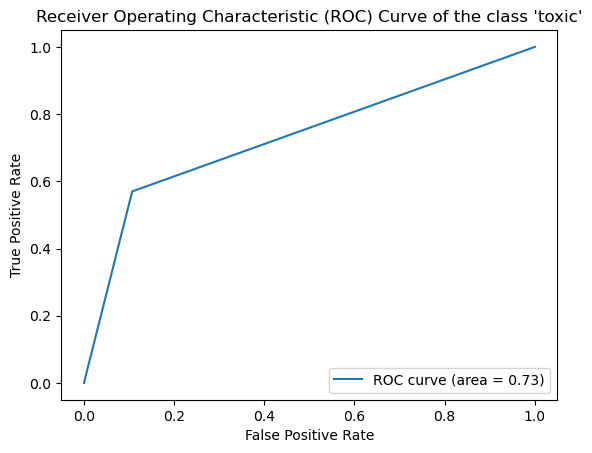

false positive rate =  [0.00000000e+00 4.55895993e-04 1.00000000e+00]
true positive rate =  [0.         0.11989101 1.        ]
threshold =  [2 1 0]
roc_auc =  0.5597175560907777


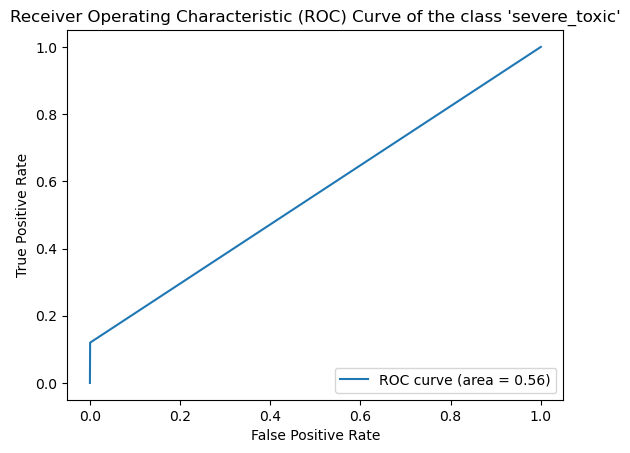

false positive rate =  [0.         0.03000647 1.        ]
true positive rate =  [0.         0.42021132 1.        ]
threshold =  [2 1 0]
roc_auc =  0.6951024278939342


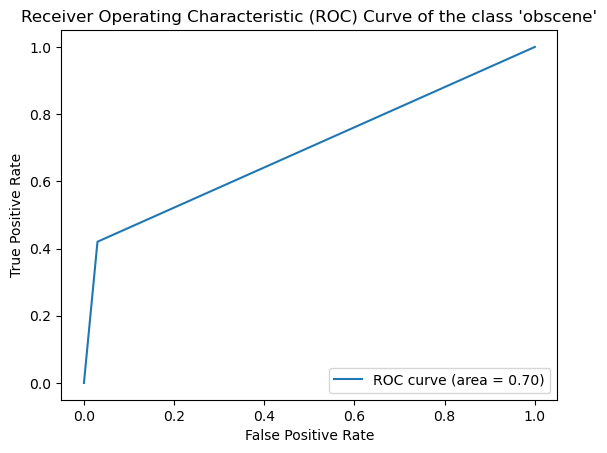

false positive rate =  [0. 1.]
true positive rate =  [0. 1.]
threshold =  [1 0]
roc_auc =  0.5


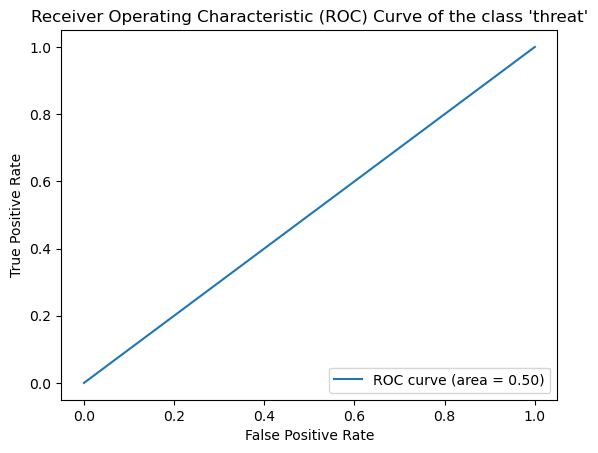

false positive rate =  [0.         0.03783587 1.        ]
true positive rate =  [0.         0.39655676 1.        ]
threshold =  [2 1 0]
roc_auc =  0.6793604406440135


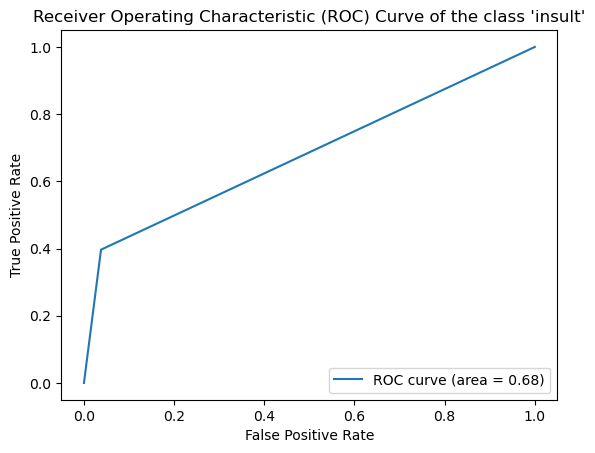

false positive rate =  [0.00000000e+00 1.58062783e-04 1.00000000e+00]
true positive rate =  [0.         0.01685393 1.        ]
threshold =  [2 1 0]
roc_auc =  0.5083479349008662


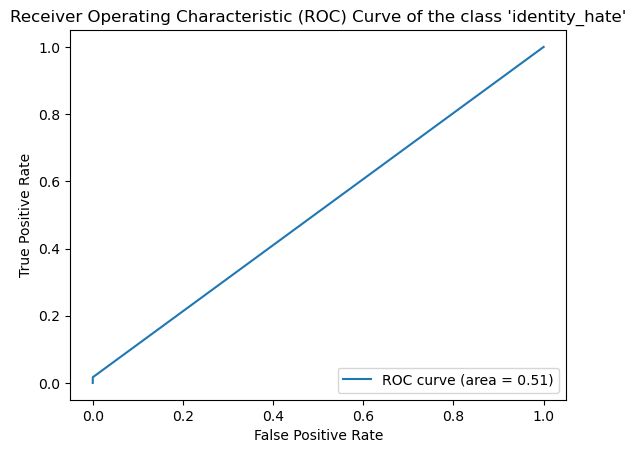

In [77]:

from sklearn.metrics import roc_curve, auc
import seaborn as sns
for idx, column in enumerate(test_labels.columns):
    true_labels = test_labels[column].values 
    predicted_labels = modified_predictions[:, idx] 
    false_pos_rate, true_pos_rate, t = roc_curve(true_labels,predicted_labels)
    print("false positive rate = ",false_pos_rate)
    print("true positive rate = ",true_pos_rate)
    print("threshold = ",t)
    roc_auc = auc(false_pos_rate, true_pos_rate)
    print("roc_auc = ",roc_auc)
    # Plot the ROC curve
    plt.figure()
    plt.plot(false_pos_rate, true_pos_rate, label='ROC curve (area = %0.2f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Receiver Operating Characteristic (ROC) Curve of the class '{column}'")
    plt.legend(loc='lower right')
    plt.show()


In [92]:
# Calculate precision score
precision = precision_score(test_labels.values.flatten(), modified_predictions.flatten(), average='macro')
print('Precision:', precision)



Precision: 0.5225855061156922


In [93]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels.values.flatten(), modified_predictions.flatten())
print('Confusion Matrix:')
print(cm)


Confusion Matrix:
[[292433  76937]
 [  8424   6074]]


toxic


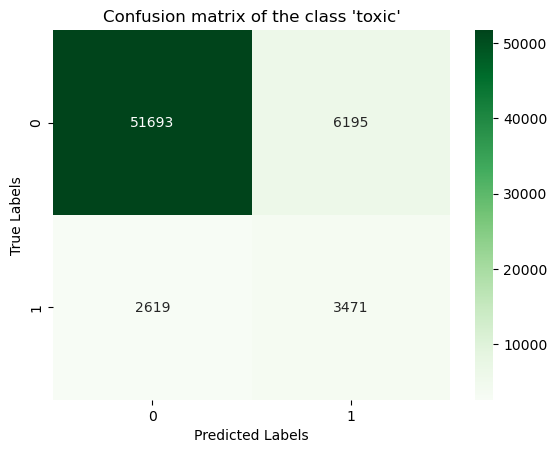

severe_toxic


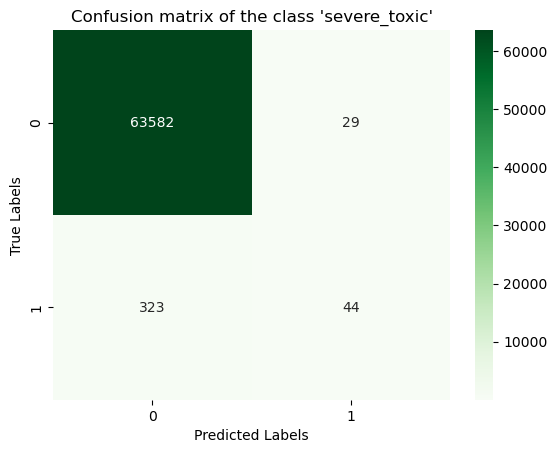

obscene


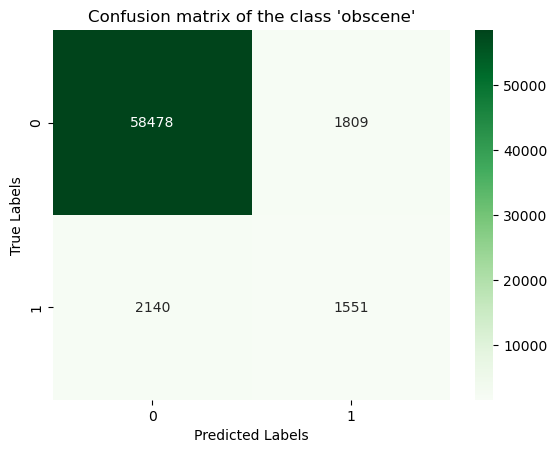

threat


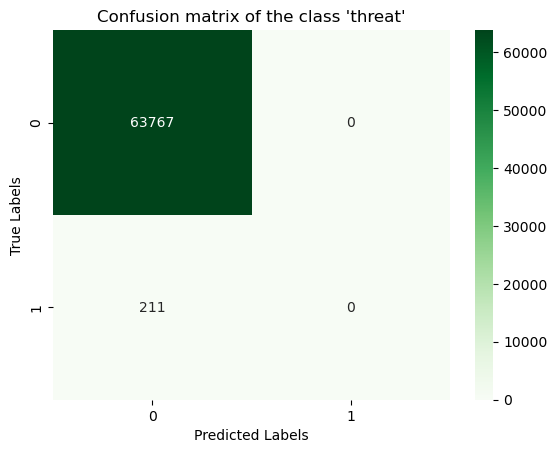

insult


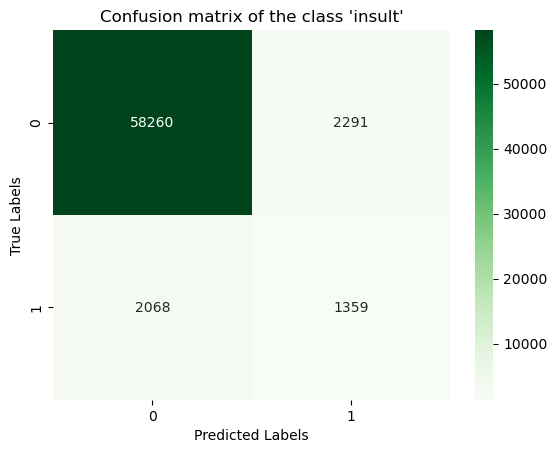

identity_hate


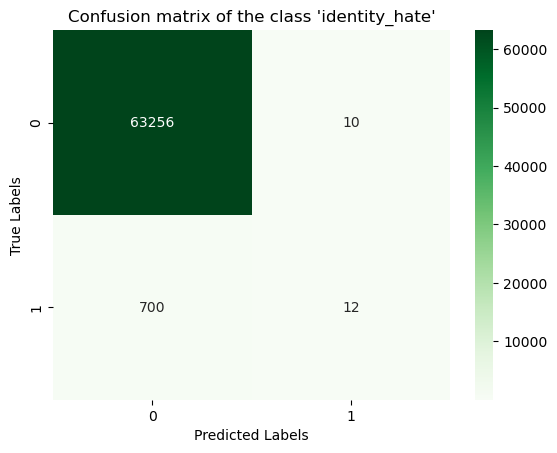

In [78]:
import seaborn as sns
for idx, column in enumerate(test_labels.columns):
    print(column)
    true_labels = test_labels[column].values 
    predicted_labels = modified_predictions[:, idx] 
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Greens')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"Confusion matrix of the class '{column}'")
    plt.show()